In [1]:
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import tensorflow as tf
import io
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')

tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)  

input_files = [f"file{i+1}.csv" for i in range(3)]
temp_dir = "FL_Data1/"
input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

df = [dk.read_csv(file) for file in input_files]
print(df[1].dtypes)

batch_size = 256
ratio_test_all = 0.2
features_len = len(df[1].columns) - 1
print("Feature Len: ", features_len)

def standardize_dask_df(dask_df):
    scaler = StandardScaler()
    X = dask_df.drop(columns=['label']).compute().values
    scaler.fit(X)
    for part in dask_df.to_delayed():
        part = part.compute()
        if part.empty:
            continue
        X_part = part.drop(columns=['label']).values
        X_scaled = scaler.transform(X_part)
        part.iloc[:, :-1] = X_scaled
        yield part

scaled_dfs = []
for dask_df in df:
    scaled_parts = list(standardize_dask_df(dask_df))
    scaled_df = dk.from_pandas(pd.concat(scaled_parts), npartitions=dask_df.npartitions)
    scaled_dfs.append(scaled_df)

train_dfs = []
val_dfs = []
test_dfs = []
for dff in scaled_dfs:
    train_df, val_test_df = dff.random_split([1 - ratio_test_all, ratio_test_all])
    test_df, val_df = val_test_df.random_split([1 - 0.25, 0.25])
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

def dask_to_tf_dataset(dask_df, batch_size):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
    output_signature = (
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

train_gens = [dask_to_tf_dataset(train_df, batch_size).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size).repeat() for test_df in test_dfs]

from server_no_HE import Server
from client_no_HE import Client
import datetime
import tenseal as ts

num_servers = 1
num_clients = 3

stepsPerEpoch_Clients = [int(np.ceil(train_dfs[index].shape[0].compute()) / batch_size) for index in range(num_clients)]
stepsValidate_Clients = [int(np.ceil(val_dfs[index].shape[0].compute()) / batch_size) for index in range(num_clients)]
stepsTest_Clients = [int(np.ceil(test_dfs[index].shape[0].compute()) / batch_size) for index in range(num_clients)]

active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)


agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list)
                 for clientID, client_name in enumerate(active_clients_list)}
temp_dir_log = clientObjects['client_0'].get_temp_dir()
for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

# Giải phóng DataFrame sau khi không cần thiết
del train_dfs, val_dfs, test_dfs

server = agents_dict['server']['server_0']
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()

2025-05-27 20:09:43.334012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 20:09:43.517549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748351383.586805  258855 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748351383.606376  258855 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748351383.756604  258855 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

['FL_Data1/file1.csv', 'FL_Data1/file2.csv', 'FL_Data1/file3.csv']
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min            

I0000 00:00:1748351406.968087  258855 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


['server_0']
['client_0', 'client_1', 'client_2']
federated_learning_log/Month05-Day27-20h-10p
Train steps:  6372
Val steps:  398
Test steps:  1195
Train steps:  4779
Val steps:  296
Test steps:  897
Train steps:  4775
Val steps:  298
Test steps:  900
====================================== Đang chạy Iteration 1 ======================================
Epoch 1/5
Epoch 1/5
Epoch 1/5


I0000 00:00:1748351411.238964  258925 service.cc:152] XLA service 0x7f7ca0005620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748351411.239057  258925 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1748351411.258154  258923 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748351411.409567  258925 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-05-27 20:10:12.829138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-27 20:10:14.569403: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-27 20:10:14.673262: E e

4978/6372 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6205 - loss: 3.7813

2025-05-27 20:10:42.593632: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4775/4775 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.6175 - loss: 3.8025 - val_accuracy: 0.9785 - val_loss: 3.2745
Epoch 2/5
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.5714 - loss: 3.8661 - val_accuracy: 0.9089 - val_loss: 3.3433
Epoch 2/5
6372/6372 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.6365 - loss: 3.7383 - val_accuracy: 0.9584 - val_loss: 3.1683
Epoch 2/5
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8343 - loss: 3.2519 - val_accuracy: 0.9821 - val_loss: 2.8358
Epoch 3/5
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.7418 - loss: 3.2986 - val_accuracy: 0.9572 - val_loss: 2.9140
Epoch 3/5
6372/6372 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8217 - loss: 3.0742 - val_accuracy: 0.9845 - val_loss: 2.6386
Epoch 3/5
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9042 - loss: 2.8249 - val_accuracy: 0.9828 - val_loss: 2.4540
Epoch 4/5
4779/4779 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8183 - loss: 2.8657 - val_accura

In [7]:
from tensorflow.keras.models import load_model

#tempdirs = [f"federated_learning_log/Month05-Day27-15h-12p/client_{i}_log/" for i in range(len(active_clients_list))]
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

model_names =[f"global_model_iter_{i+1}.keras" for i in range(4)]
print(model_names)
models = {}

for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i]+model_name) for model_name in model_names]
print (models['client_0'])

['global_model_iter_1.keras', 'global_model_iter_2.keras', 'global_model_iter_3.keras', 'global_model_iter_4.keras']
[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


307096
<Sequential name=sequential, built=True>
9597/9597 ━━━━━━━━━━━━━━━━━━━━ 10s 971us/step
<Sequential name=sequential, built=True>
9597/9597 ━━━━━━━━━━━━━━━━━━━━ 10s 988us/step
<Sequential name=sequential, built=True>
9597/9597 ━━━━━━━━━━━━━━━━━━━━ 10s 998us/step
<Sequential name=sequential, built=True>
9597/9597 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Precision Score:  [0.9807039703591428, 0.9999039621861547, 1.0, 1.0]
Recall Score:  [0.9693497910875102, 0.9965625156060127, 0.9987806502089125, 0.9995006075940939]
F1 Score:  [0.9749938258944082, 0.9982304426394543, 0.9993899531742214, 0.9997502414332812]


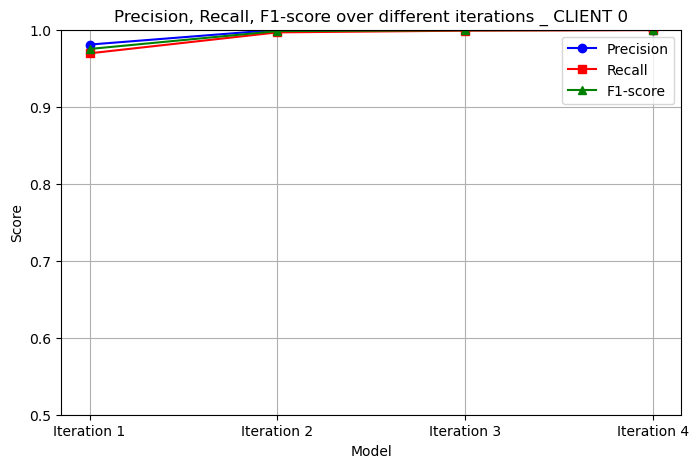

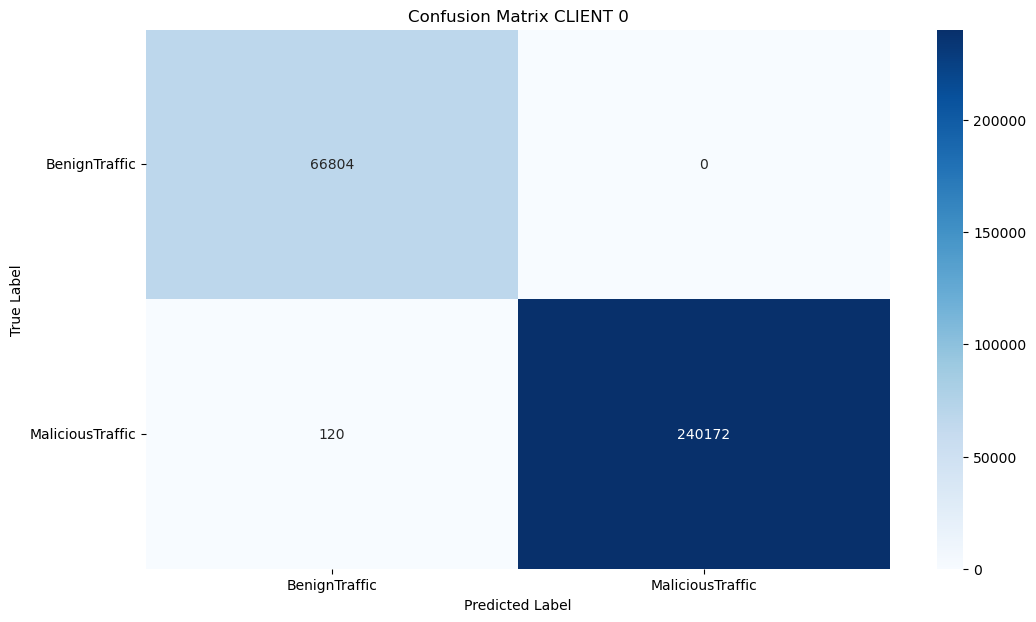

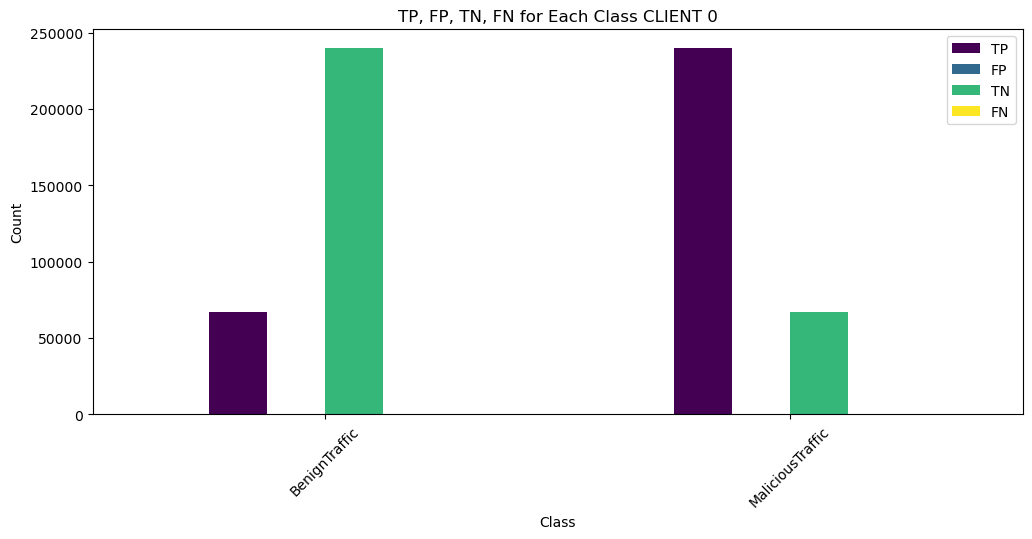

In [8]:
# Client 0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(4)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['BenignTraffic', 'MaliciousTraffic']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")

# Hiển thị
plt.show()

metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 0")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

230884
<Sequential name=sequential_1, built=True>
7216/7216 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
<Sequential name=sequential_1, built=True>
7216/7216 ━━━━━━━━━━━━━━━━━━━━ 7s 996us/step
<Sequential name=sequential_1, built=True>
7216/7216 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
<Sequential name=sequential_1, built=True>
7216/7216 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Precision Score:  [0.9999399656946827, 0.9999723617951567, 1.0, 1.0]
Recall Score:  [0.6422299828140836, 0.9964746838232054, 0.998722072885912, 0.9995152690256908]
F1 Score:  [0.7821254159064076, 0.998220458928468, 0.9993606279074895, 0.9997575757575757]


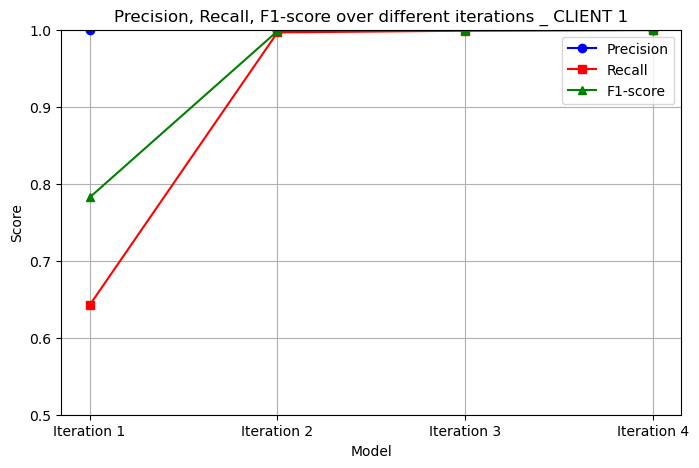

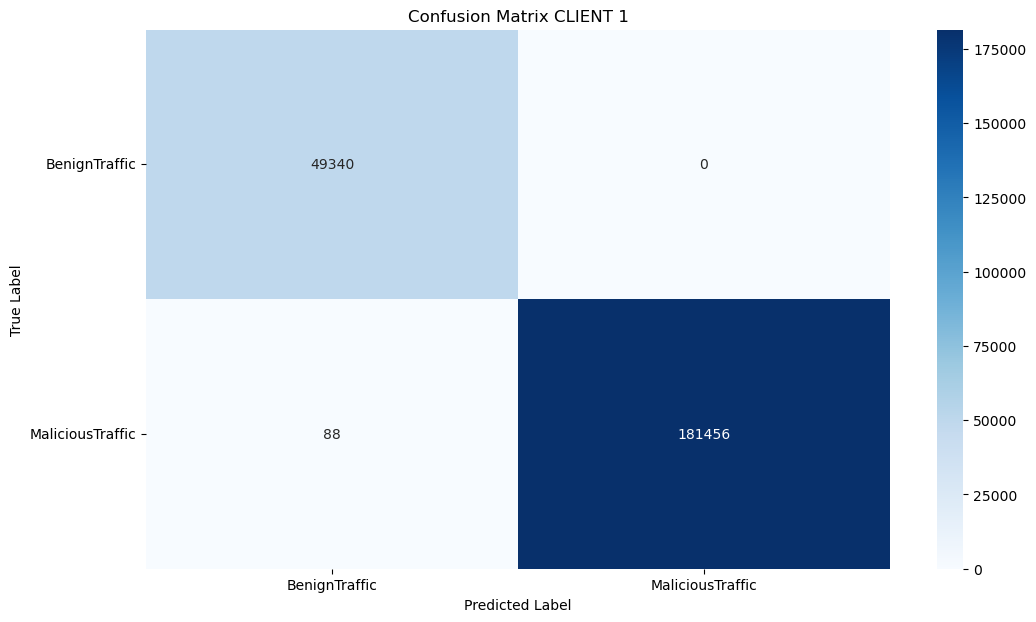

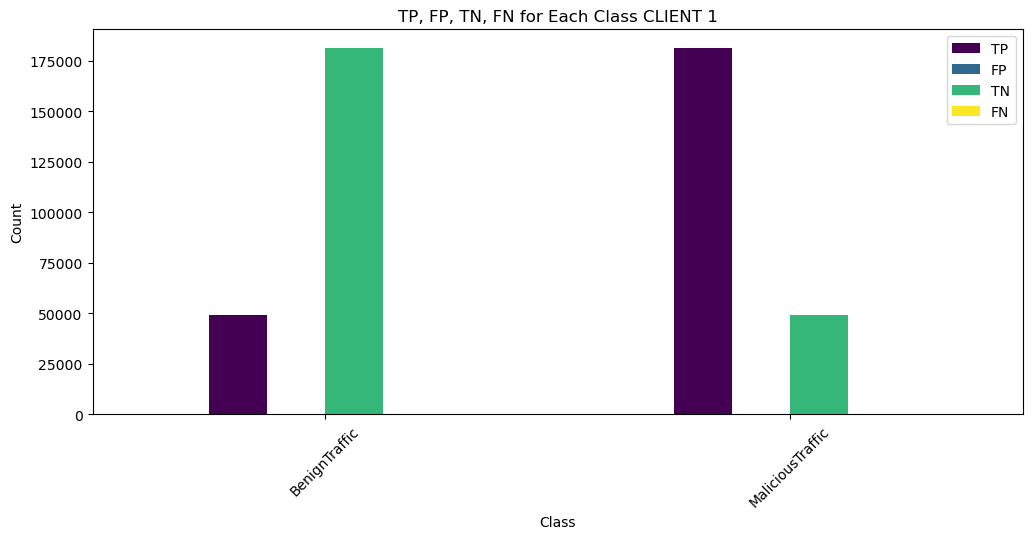

In [9]:
#Client 1

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(4)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[1].take(stepsTest_Clients[1]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_1'][iteration])
    y_pred_pre = models['client_1'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 1")
plt.legend()
plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['BenignTraffic', 'MaliciousTraffic']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.show()


metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 1")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

231274
<Sequential name=sequential_2, built=True>
7228/7228 ━━━━━━━━━━━━━━━━━━━━ 7s 1000us/step
<Sequential name=sequential_2, built=True>
7228/7228 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
<Sequential name=sequential_2, built=True>
7228/7228 ━━━━━━━━━━━━━━━━━━━━ 7s 994us/step
<Sequential name=sequential_2, built=True>
7228/7228 ━━━━━━━━━━━━━━━━━━━━ 7s 989us/step
Precision Score:  [0.9943390340055022, 0.9999391952771314, 1.0, 1.0]
Recall Score:  [0.9656693971762088, 0.9965129538531033, 0.9985952657702075, 0.9994766676398812]
F1 Score:  [0.9797945358612055, 0.9982231345672063, 0.9992971392188047, 0.9997382653328301]


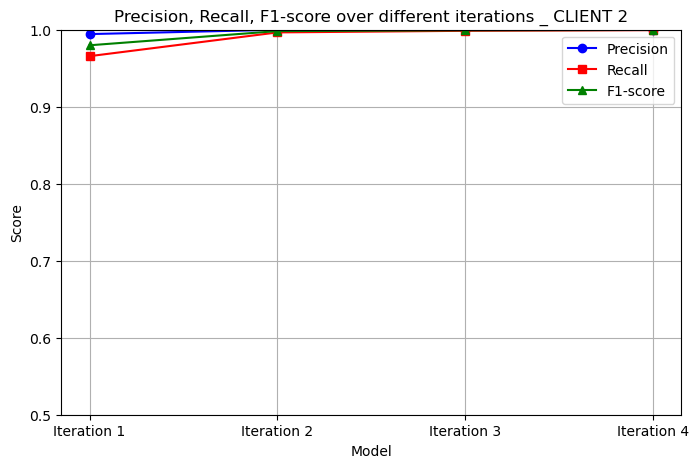

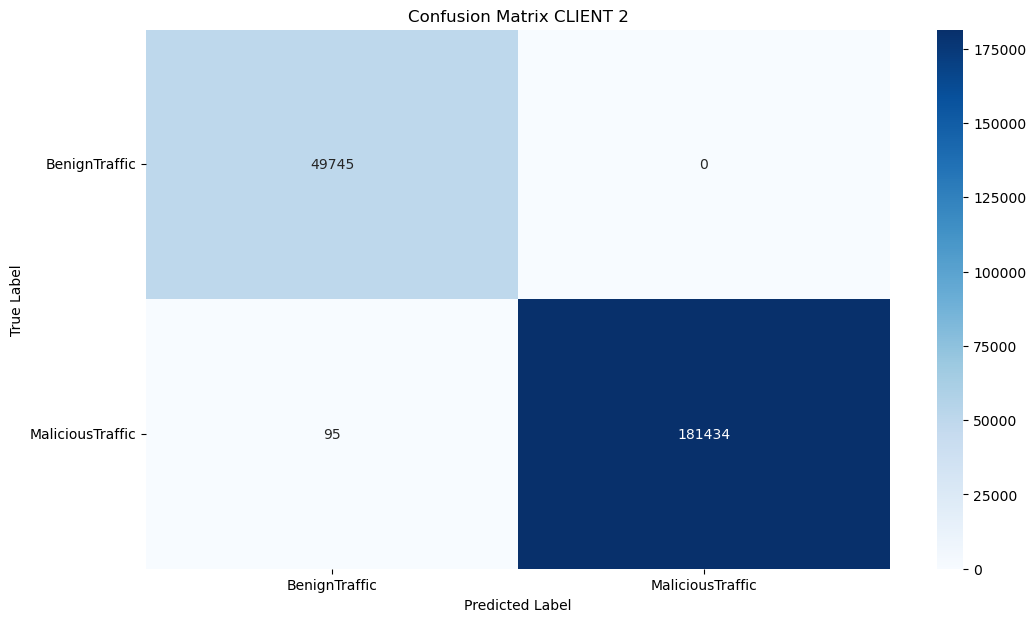

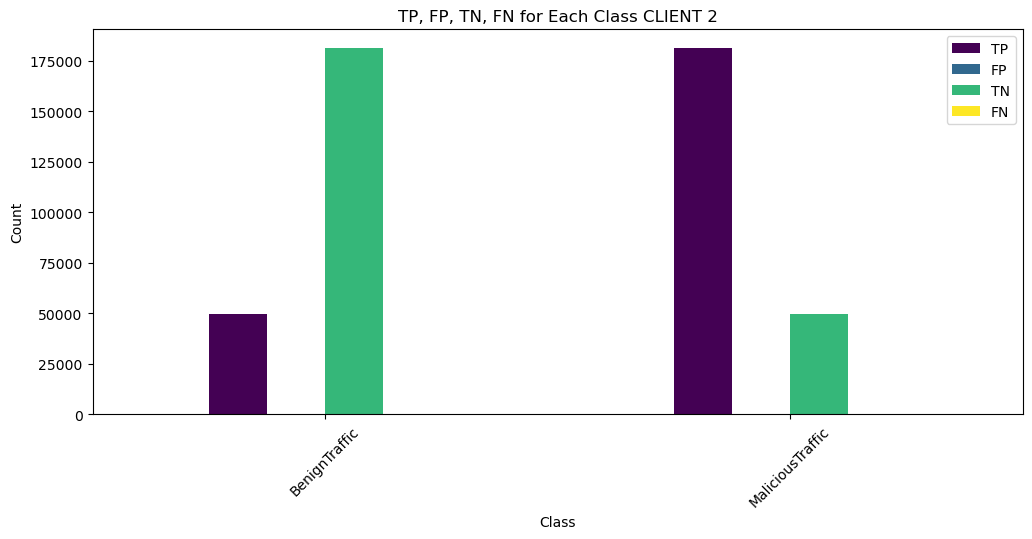

In [10]:
#Client 2

precisions = []
recalls = []
f1s = []

Iterations = [f"Iteration {index+1}" for index in range(4)]

X_test = []
y_test = []
for X_batch, y_batch in test_gens[2].take(stepsTest_Clients[2]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(len(Iterations)):
    print(models['client_2'][iteration])
    y_pred_pre = models['client_2'][iteration].predict(X_test, verbose=1)
    y_pred = (y_pred_pre > 0.5).astype(int).flatten()
    
    precisions.append(precision_score(y_test, y_pred, average='binary'))
    recalls.append(recall_score(y_test, y_pred, average='binary'))
    f1s.append(f1_score(y_test, y_pred, average='binary'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  


# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.ylim(0.5, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


attack_types = ['BenignTraffic', 'MaliciousTraffic']
cm = confusion_matrix(y_test, y_pred)
    # Vẽ heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.show()


metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 2")
plt.xticks(rotation=45)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv']


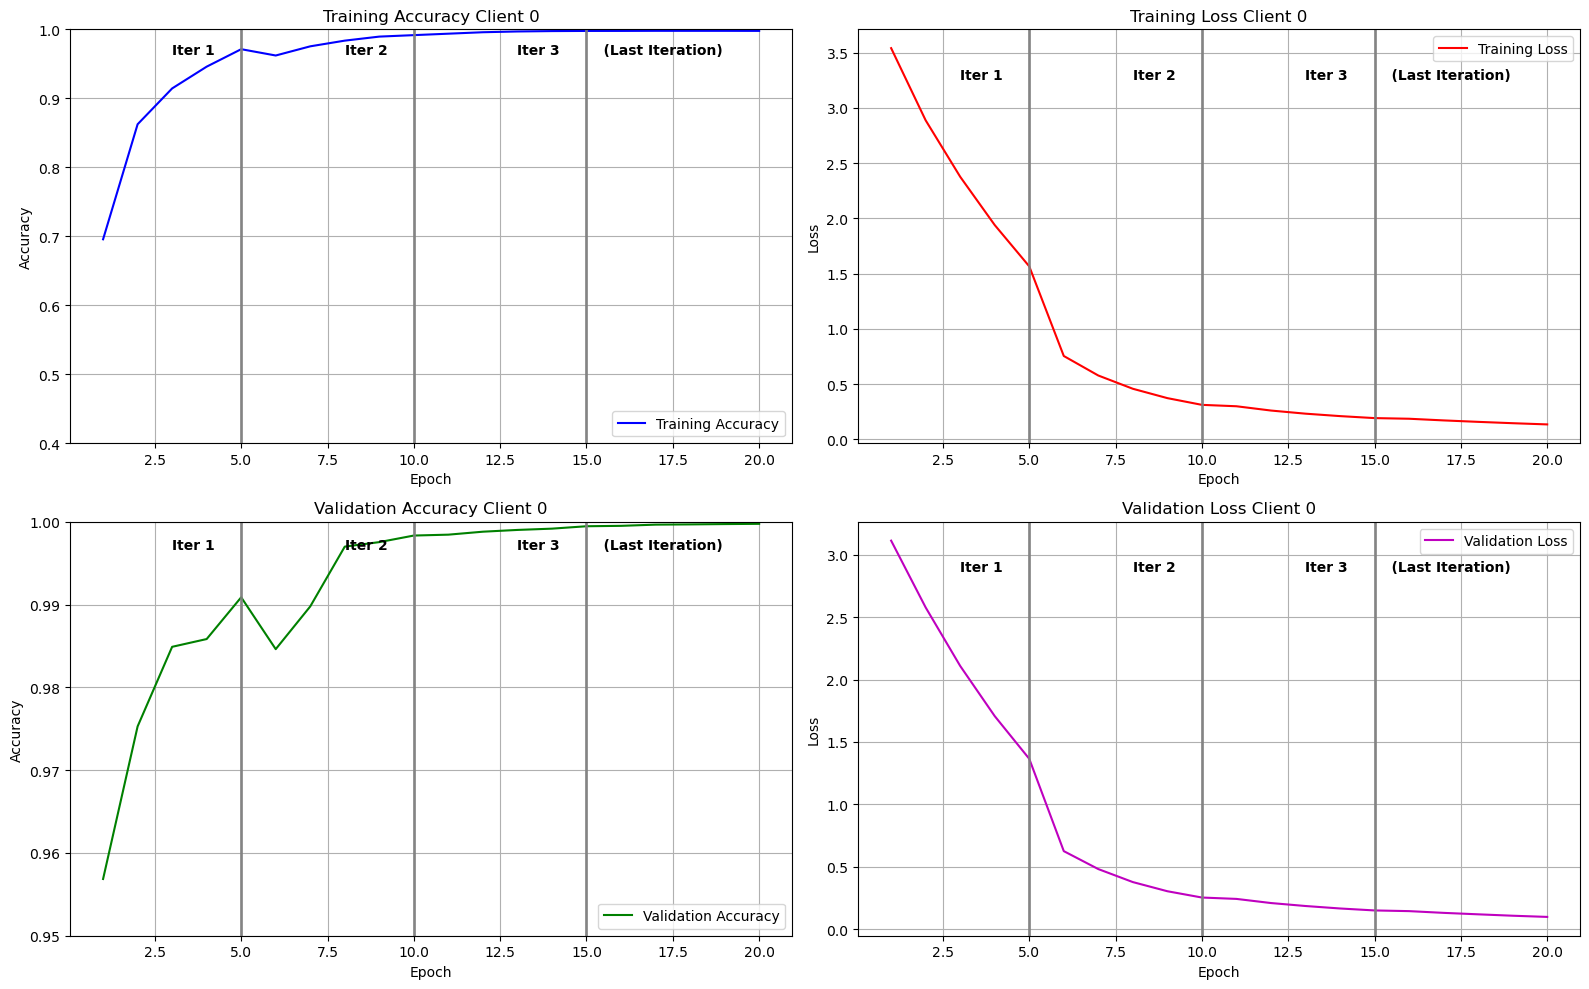

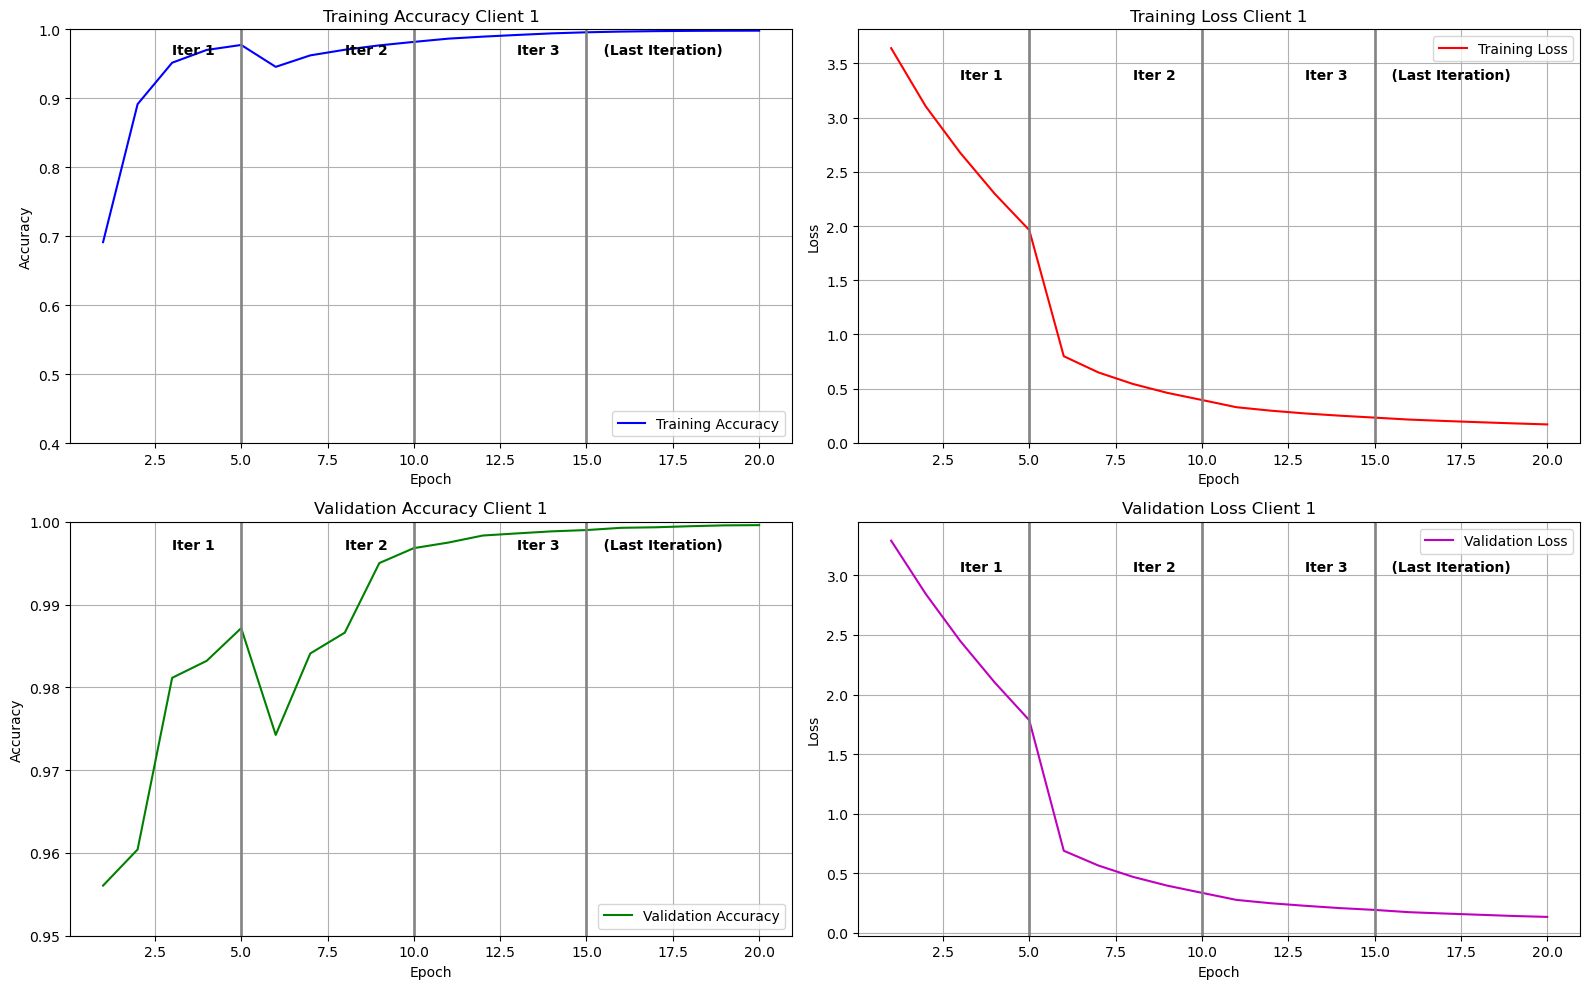

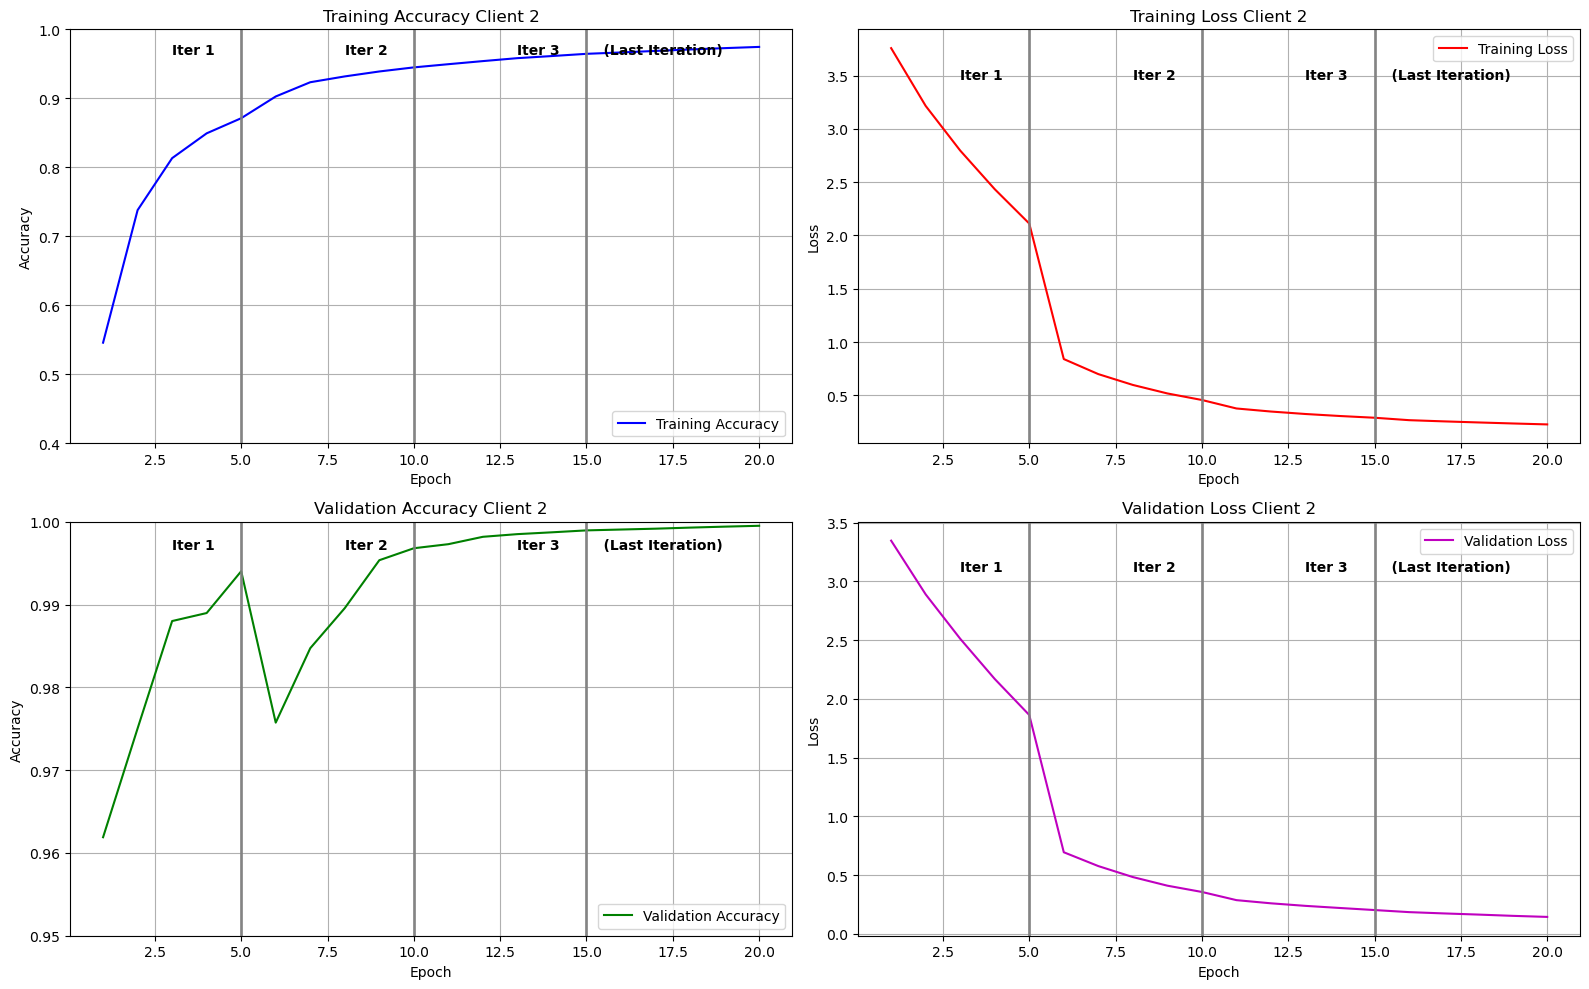

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Giả định tempdirs đã được định nghĩa
# Ví dụ: tempdirs = [f"federated_learning_log/21h-04p-Month05-Day27/client_{i}_log/" for i in range(4)]
#tempdirs = [f"federated_learning_log/Month05-Day27-15h-12p/client_{i}_log/" for i in range(4)]  # 4 clients
log_names = [f"Iteration_{i+1}.csv" for i in range(4)]
print(log_names)

# Vẽ biểu đồ cho từng client
for i in range(3):
    # Kết hợp dữ liệu từ các file log
    all_logs = []
    for log_name in log_names:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    # Kết hợp dữ liệu từ các file log
    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)  # Tổng cộng 20 epoch (4 iterations x 5 epochs)

    plt.figure(figsize=(16, 10))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    # Thêm đường kẻ dọc tại epoch 5, 10, 15
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:  
            plt.text(iter_idx * 5 - 2, 0.98, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:  # Iter 4
            plt.text(iter_idx * 5 - 2, 0.98, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Accuracy Client {i}')
    plt.title(f'Training Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.ylim(0.40, 1.0)

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss Client {i}')
    plt.title(f'Training Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, 0.998, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, 0.998, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.ylim(0.95, 1.0)

    # Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
    for iter_idx in range(1, len(log_names)):
        plt.axvline(x=iter_idx * 5, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < len(log_names) - 1:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(iter_idx * 5 - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}         (Last Iteration)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()